# Exploratory Data Analysis (EDA)

In [1]:
import pandas as pd

/tmp/ipykernel_4630/4080736814.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## Song attributes
- These attributes can be used as features for a content-based approach
- Using both Year and Artist as features can be useful for a similarity-based approach

In [2]:
df_song = pd.read_pickle('data/song_cleaned.pkl')
df_song['year'] = df_song['year'].astype(str)
df_song.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999056 entries, 0 to 999055
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   song_num     999056 non-null  int32 
 1   title        999041 non-null  object
 2   release      999056 non-null  object
 3   artist_name  999056 non-null  object
 4   year         999056 non-null  object
dtypes: int32(1), object(4)
memory usage: 34.3+ MB


### Binning Analysis for Artist

In [3]:
def bin_counts(series, bins, labels=None):
    bins = pd.cut(series, bins=bins, labels=labels, include_lowest=True, right=True)
    bins_counts = bins.value_counts()
    total = bins_counts.sum()
    return pd.DataFrame(data={
    "bin": bins_counts.index,
    "counts": bins_counts.values,
    "percentage": bins_counts.values / total * 100})

In [4]:
bin_counts(df_song['artist_name'].value_counts(), bins=[1,2,5,25,50,float('inf')],
           labels=['One', '2-5', '6-25', '26-50', '50 or more'])

,bin,counts,percentage
0,One,32575,44.834563
1,6-25,20481,28.189000
2,26-50,9432,12.981722
3,2-5,6119,8.421878
4,50 or more,4049,5.572836


### Binning Analysis for Release Year

In [5]:
bin_counts(df_song['year'].value_counts(), bins=[1,10,100,1000,5000,float('inf')],
           labels=['1', '10', '100', '1000', '5000 or more'])

,bin,counts,percentage
0,10,26,28.888889
1,5000 or more,25,27.777778
2,1000,22,24.444444
3,100,12,13.333333
4,1,5,5.555556


### Songs per Year and Artist

/tmp/ipykernel_4630/3165332247.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontdict={'fontsize': 6})


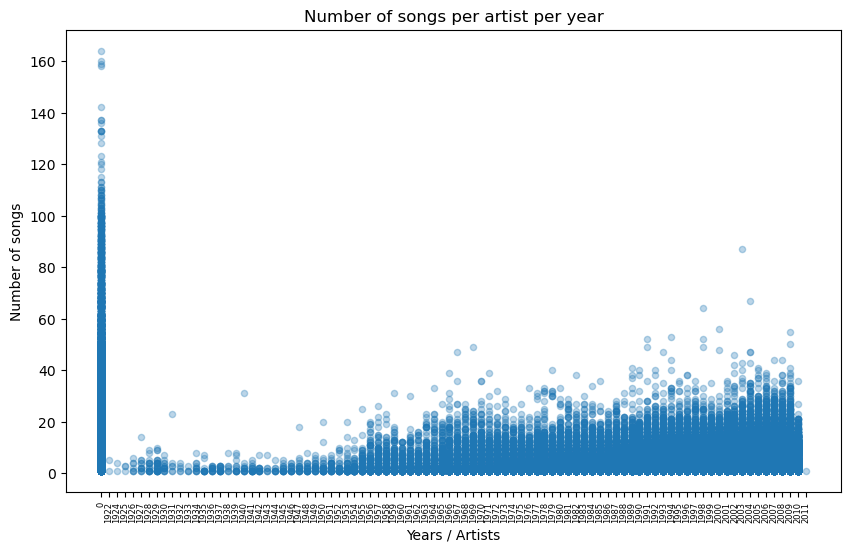

In [6]:
ax = df_song.groupby(['year', 'artist_name']).size().reset_index(name='count').plot(kind='scatter', x='year', y='count',
                                                                               title='Number of songs per artist per year', figsize=(10, 6),
                                                                               xlabel='Years / Artists', ylabel='Number of songs', alpha=0.3)
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontdict={'fontsize': 6})

## User-Item Interactions
- Only 1% of the songs have been listened to; the cold start problem will affect the remaining 99% of the songs.
- There is no additional information about the users, so we will assume that the user-item interactions are the only source of information. However, we can also assume that songs newly added to the dataset initially present a cold start problem.
- The normalization of the play count using MinMax scaling will be useful for model training.
- Song User-Plays Ratio can be used for implementing a song score for the recommendation system.

In [7]:
df_play = pd.read_pickle('data/play_cleaned.pkl')
df_play.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000000 entries, 0 to 1999999
Data columns (total 3 columns):
 #   Column      Dtype
---  ------      -----
 0   user_num    int32
 1   song_num    int32
 2   play_count  int64
dtypes: int32(2), int64(1)
memory usage: 30.5 MB


In [8]:
len(df_play['song_num'].unique()) / df_song.shape[0]

0.010009448919780273

### Binning Analysis for Play Count

In [9]:
pd.options.display.float_format = '{:.4f}'.format
df_play['play_count'].describe(percentiles=[0.25, 0.5, 0.75, 0.85, 0.90])

count   2000000.0000
mean          2.8439
std           3.9940
min           1.0000
25%           1.0000
50%           1.0000
75%           3.0000
85%           5.0000
90%           6.0000
max          26.0000
Name: play_count, dtype: float64

In [10]:
bin_counts(df_play['play_count'], bins=[1,2,5,10,25,float('inf')],
           labels=['1', '2-5', '6-10', '11-25', '25 or more'])

,bin,counts,percentage
0,1,1451476,72.5738
1,2-5,318638,15.9319
2,6-10,134770,6.7385
3,11-25,74607,3.7304
4,25 or more,20509,1.0254


### Normalized Play Count Distribution

In [11]:
df_play['play_count_norm'] = (
    df_play['play_count'] - df_play['play_count'].min()) / (df_play['play_count'].max() - df_play['play_count'].min()
)

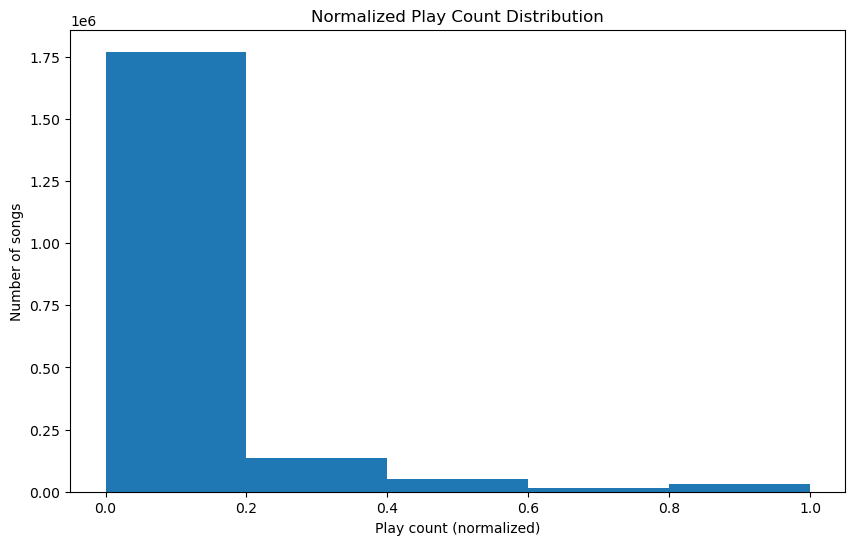

In [12]:
_ = df_play['play_count_norm'].plot(kind='hist', bins=5, title='Normalized Play Count Distribution',
                                figsize=(10, 6), xlabel='Play count (normalized)', ylabel='Number of songs')

## Song User-Plays Ratio

In [13]:
df_song_summary = pd.read_pickle('data/song_summary.pkl')
df_song_summary.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   song_num    10000 non-null  int32  
 1   user_count  10000 non-null  int64  
 2   play_count  10000 non-null  float64
dtypes: float64(1), int32(1), int64(1)
memory usage: 195.4 KB


In [14]:
df_song_summary['user_play_ratio'] = df_song_summary['user_count'] / df_song_summary['play_count']

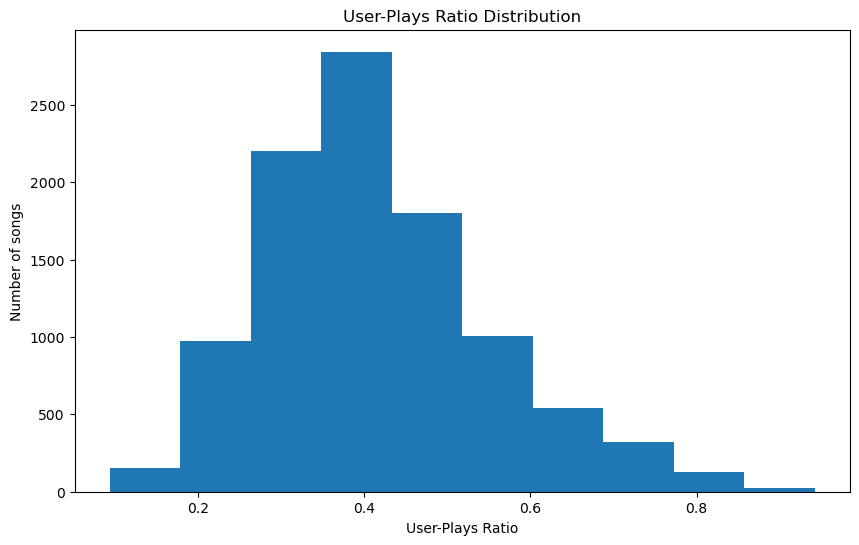

In [15]:
_ = df_song_summary['user_play_ratio'].plot(kind='hist', bins=10, title='User-Plays Ratio Distribution',
                                figsize=(10, 6), xlabel='User-Plays Ratio', ylabel='Number of songs')

## User-Year Interaction

In [16]:
df_user_summary = pd.read_pickle('data/user.pkl')
df_user_summary.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76353 entries, 0 to 76352
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   user_num       76353 non-null  int32
 1   artist_count   76353 non-null  int64
 2   title_count    76353 non-null  int64
 3   release_count  76353 non-null  int64
 4   year_count     76353 non-null  int64
dtypes: int32(1), int64(4)
memory usage: 2.6 MB


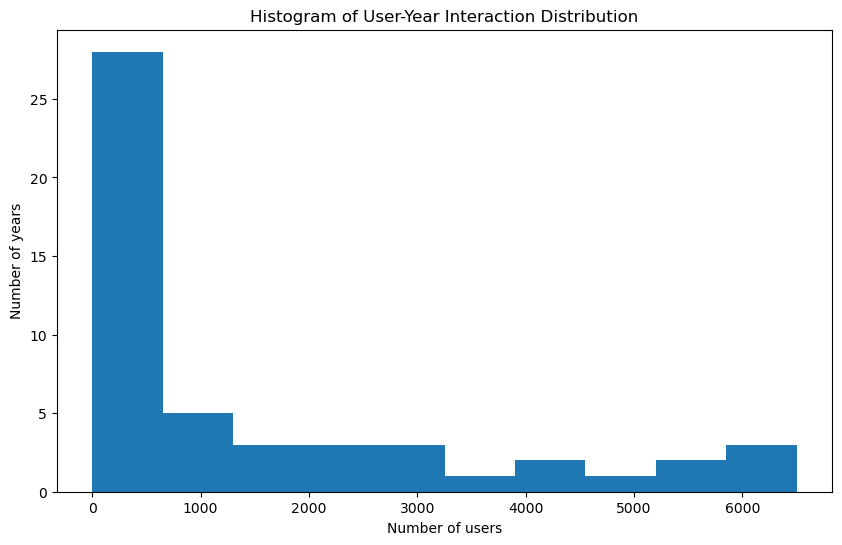

In [17]:
_ = df_user_summary['year_count'].value_counts().plot(kind='hist', bins=10,
                                    title='Histogram of User-Year Interaction Distribution',
                                    figsize=(10, 6), xlabel='Number of users', ylabel='Number of years')
                                               

## User-Artist Interaction

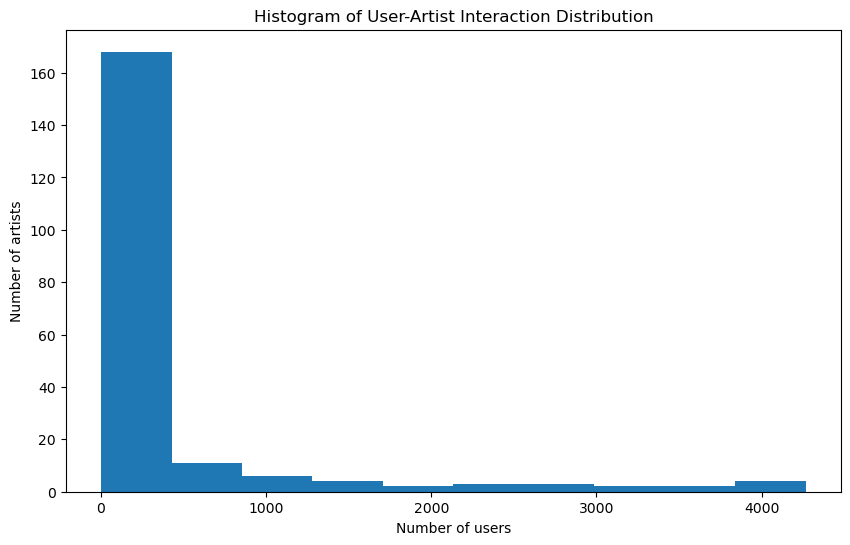

In [18]:
_ = df_user_summary['artist_count'].value_counts().plot(kind='hist', bins=10,
                                    title='Histogram of User-Artist Interaction Distribution',
                                    figsize=(10, 6), xlabel='Number of users', ylabel='Number of artists')

### Song Pairs
- 73.3% of song pairs have been listened to by the same user
- Only 5.49% of song pairs have been listened to by 6-10 users

In [19]:
df_song_pairs = pd.read_pickle('data/song_pairs.pkl')
df_song_pairs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42597082 entries, 0 to 42597081
Data columns (total 4 columns):
 #   Column     Dtype
---  ------     -----
 0   song_num1  int32
 1   song_num2  int32
 2   plays      int32
 3   users      int32
dtypes: int32(4)
memory usage: 650.0 MB


In [20]:
df_song_pairs_avg_users = df_song_pairs.groupby(['song_num1', 'song_num2']).agg({'users': 'mean'}).reset_index()
df_song_pairs_avg_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42597082 entries, 0 to 42597081
Data columns (total 3 columns):
 #   Column     Dtype  
---  ------     -----  
 0   song_num1  int32  
 1   song_num2  int32  
 2   users      float64
dtypes: float64(1), int32(2)
memory usage: 650.0 MB


In [21]:
bin_counts(df_song_pairs_avg_users['users'], bins=[1,2,5,10,25,float('inf')],
           labels=['1', '2-5', '6-10', '11-25', '25 or more'])

,bin,counts,percentage
0,1,31223070,73.2986
1,2-5,7535942,17.6912
2,6-10,2337078,5.4865
3,11-25,1099274,2.5806
4,25 or more,401718,0.9431


## User pairs
- The vast majority of user pairs (83.48%) have only one song in common.
- Only 2.9% of users have listened to the same 6-10 songs.
- Percentages are lower than for item pairs; however, due to a larger number of users, the 6-10 songs interactions amount to 22.61 million.
- Given the large base of users and the significant volume of shared music interests (even for the 6-10 songs category), implementing user-user collaborative filtering could be beneficial.

In [22]:
df_user_pairs = pd.read_pickle('data/user_pairs.pkl')
df_user_pairs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 769868292 entries, 0 to 769868291
Data columns (total 4 columns):
 #   Column     Dtype
---  ------     -----
 0   user_num1  int32
 1   user_num2  int32
 2   plays      int32
 3   songs      int32
dtypes: int32(4)
memory usage: 11.5 GB


In [23]:
bin_counts(df_user_pairs['songs'], bins=[1,2,5,10,float('inf')],
           labels=['1', '2-5', '6-10', '11 or more'])

,bin,counts,percentage
0,1,642676922,83.4788
1,2-5,97916778,12.7186
2,6-10,22610324,2.9369
3,11 or more,6664268,0.8656


In [24]:
df_user_pairs = None # release memory